<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import netCDF4 as nc
config = tf.ConfigProto()
config.gpu_options.allow_growth = True   # Allocates as much memory as needed.
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
model_dir = '/export/home/srasp/TF_models/'

In [3]:
model_fn = 'saved_keras_model_0214b.h5'

In [4]:
mean_fn = 'mean_nolat_0213.nc'
std_fn = 'std_nolat_0213.nc'

In [5]:
model = keras.models.load_model(model_dir + model_fn, custom_objects={"tf": tf})

/export/home/srasp/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_1 (Activation)    (None, 7, 30, 1)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 210)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              216064    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 60)                61500     
__________

In [7]:
mean = nc.Dataset(model_dir + mean_fn)
std = nc.Dataset(model_dir + std_fn)

In [8]:
mean

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): level(30), lats(1), lon(1)
    variables(dimensions): float32 QAP(level,lats,lon), float32 TAP(level,lats,lon), float32 QBP(level,lats,lon), float32 TBP(level,lats,lon), float32 dTdt_adiabatic(level,lats,lon), float32 dQdt_adiabatic(level,lats,lon), float32 SPDT(level,lats,lon), float32 SPDQ(level,lats,lon), float32 TPHYSTND_NORAD(level,lats,lon), float32 PHQ(level,lats,lon), float32 SHFLX(lats,lon), float32 LHFLX(lats,lon), float32 PS(), float32 lat(), float32 SOLIN()
    groups: 

In [9]:
data_dir = '/beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05/'

In [10]:
aqua = nc.Dataset(data_dir + 'AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-05-00000.nc')

In [11]:
aqua

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    source: CAM
    case: AndKua_aqua_SPCAM3.0_enhance05
    title: 
    logname: tg847872
    host: 
    Version: $Name:  $
    revision_Id: $Id: history.F90,v 1.26.2.38 2003/12/15 18:52:35 hender Exp $
    dimensions(sizes): lat(64), lon(128), lev(30), ilev(31), isccp_prs(7), isccp_tau(7), isccp_prstau(49), time(48), tbnd(2), chars(8), crm_x(8), crm_y(1), crm_z(28)
    variables(dimensions): float64 P0(), float64 lat(lat), float64 lon(lon), float64 crm_x(crm_x), float64 crm_y(crm_y), float64 crm_z(crm_z), float64 lev(lev), float64 ilev(ilev), float64 isccp_prs(isccp_prs), float64 isccp_tau(isccp_ta), float64 isccp_prstau(isccp_prsta), float64 time(time), float64 time_bnds(time,tbnd), |S1 date_written(time,chars), |S1 time_written(time,chars), int32 ntrm(), int32 ntrn(), int32 ntrk(), int32 ndbase(), int32 nsbase(), int32 nbdate(), int32 nbsec(), int32 mdt(), int32 

In [12]:
# TBP,QBP,PS,SHFLX,LHFLX,dTdt_adiabatic,dQdt_adiabatic,lat
inps = ['TBP','QBP','PS','SHFLX','LHFLX','dTdt_adiabatic','dQdt_adiabatic']

In [13]:
outps = ['TPHYSTND_NORAD','PHQ']

In [14]:
def convert_ds(ds, vars, nlev=30):
    """Convert to [sample, feature, lev, 1]"""
    arr = []
    for var in vars:
        da = ds[var][:]
        m = mean[var][:]; s = std[var][:]
        da = (da - m) / s   # Pierre is normalizing both inputs and outputs. Is that right?
        if da.ndim == 4:   # 3D variables [time, lev, lat, lon] --> [sample, lev]
            a = np.rollaxis(da, 1, 4).reshape(-1, 30)
        elif da.ndim == 3:   # 2D variables [time, lat, lon]
            a = np.rollaxis(np.tile(da.reshape(-1), (30, 1)), 0, 2)
        elif da.ndim == 1:   # lat
            a = np.rollaxis(np.tile(da, (48, 30, 128, 1)), 1, 4).reshape(-1, 30)
        else:
            raise Exception('Incompatible number of dimensions')
        arr.append(a)
    arr = np.expand_dims(np.rollaxis(np.array(arr), 0, 2), 3) # [sample, feature, lev, 1]
    return arr[:, :, -nlev:][:, :, ::-1]   # I think this should be true for inputs and outputs

In [15]:
inp_arr = convert_ds(aqua, inps)

In [16]:
outp_arr = convert_ds(aqua, outps)

In [17]:
preds = model.predict(inp_arr, batch_size=1024)

In [18]:
preds.shape, outp_arr.shape

((393216, 2, 30, 1), (393216, 2, 30, 1))

In [19]:
preds_re = preds.reshape(48, 64, 128, -1, 30); preds_re.shape

(48, 64, 128, 2, 30)

In [20]:
def denorm(arr, vars, nlev=30):
    # Inputs [sample, feature, lev, 1]
    a = np.copy(arr)
    a = a.reshape(48, 64, 128, -1, nlev)  # [time, lat, lon, feature, lev]
    for i, var in enumerate(vars):
        m = np.rollaxis(mean[var][-nlev:][::-1], 0, 3) 
        s = np.rollaxis(std[var][-nlev:][::-1], 0, 3) 
        a[:, :, :, i, :] = a[:, :, :, i, :] * s + m
    return a

In [21]:
preds_de = denorm(preds, outps); preds_de.shape

(48, 64, 128, 2, 30)

In [22]:
out_de = denorm(outp_arr, outps)

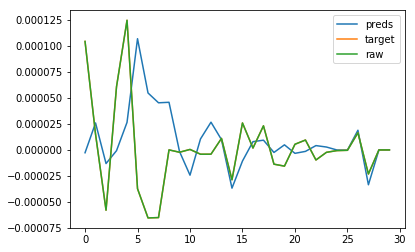

In [63]:
plt.plot(preds_de[4, 30, 60, 0, :], label='preds')
plt.plot(out_de[4, 30, 60, 0, :], label='target')
plt.plot(aqua['TPHYSTND_NORAD'][4, ::-1, 30, 60], label='raw')
plt.legend();

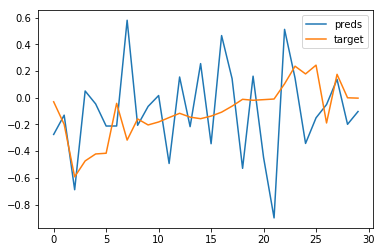

In [68]:
plt.plot(preds[0, 0, :, 0], label='preds')
plt.plot(outp_arr[0, 0, :, 0], label='target')
plt.legend();

IndexError: too many indices for array

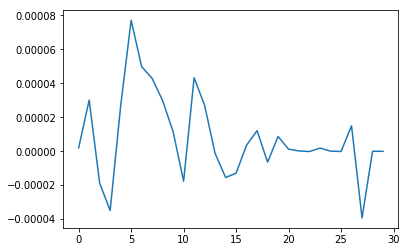

In [67]:
plt.plot(preds_de[5, 30, 70, 0, :], label='preds')
plt.plot(outp_arr[5, 30, 70, 0, :], label='target')
plt.legend();

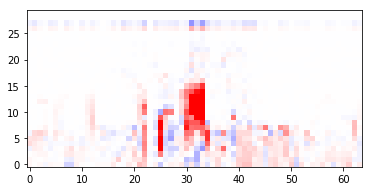

In [46]:
plt.imshow(out_de[5, :, 38, 0, :].T, origin='lower', cmap='bwr', vmin=-5e-4, vmax=5e-4)

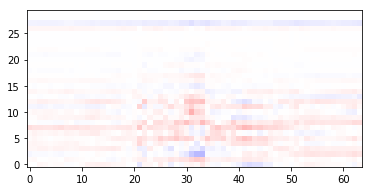

In [47]:
plt.imshow(preds_de[5, :, 38, 0, :].T, origin='lower', cmap='bwr', vmin=-5e-4, vmax=5e-4)

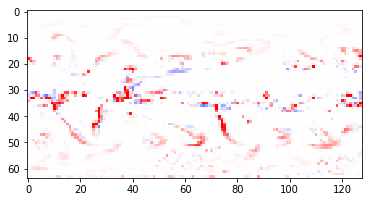

In [44]:
plt.imshow(out_de[5, :, :, 0, 10], cmap='bwr', vmin=-5e-4, vmax=5e-4)

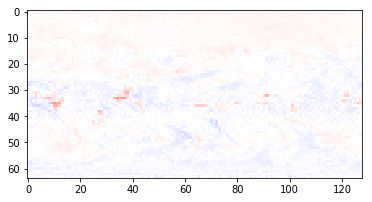

In [45]:
plt.imshow(preds_de[5, :, :, 0, 10], cmap='bwr', vmin=-5e-4, vmax=5e-4)